In [ ]:
# %%bash
# cd /content/drive/MyDrive/HsoubCourse/cps
# rm *.keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from PIL import ImageOps
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
train_ds, train_metadata = tfds.load('Food101', split='train', shuffle_files=True, as_supervised=True, batch_size=128, with_info=True)
val_ds, val_metadata = tfds.load('Food101', split='validation', shuffle_files=True, as_supervised=True, batch_size=128, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteE1TBGZ/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteE1TBGZ/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
print(train_metadata.features["label"].num_classes)
print(train_metadata.features["label"].names)

101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso

In [ ]:
sample_data = list(train_ds.take(1))

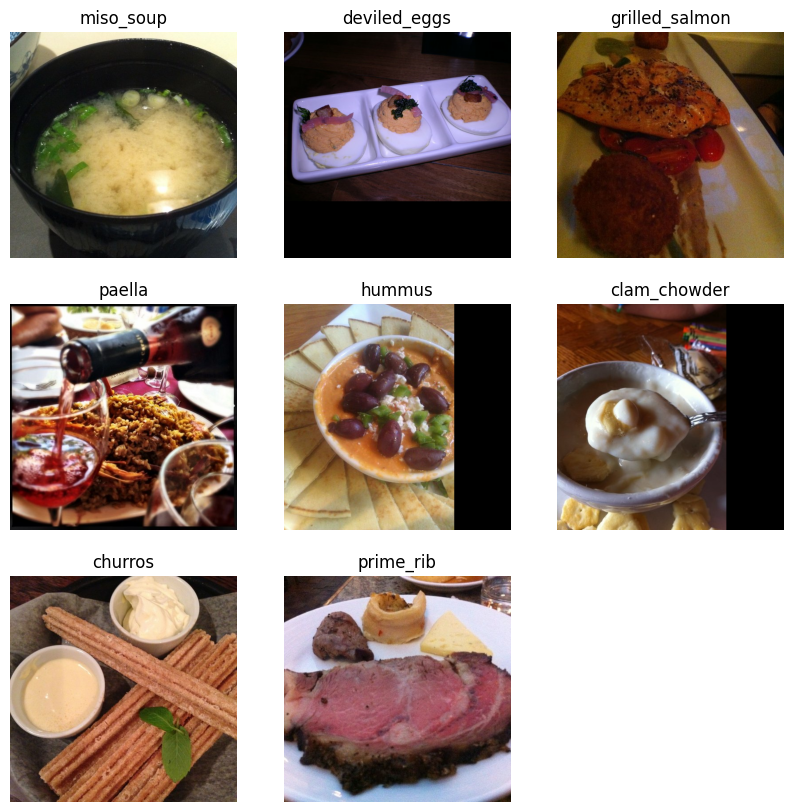

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_metadata.features["label"].int2str(labels[i].numpy().astype("uint8")))
        plt.axis("off")

In [ ]:
from tqdm import tqdm

data_info = {
    class_name: 0
    for class_name in train_metadata.features["label"].names
}
for _, label in tqdm(train_ds):
  for value in label:
    class_id = int(value)
    class_name = train_metadata.features["label"].int2str(class_id)
    data_info[class_name] += 1

100%|██████████| 592/592 [03:29<00:00,  2.83it/s]


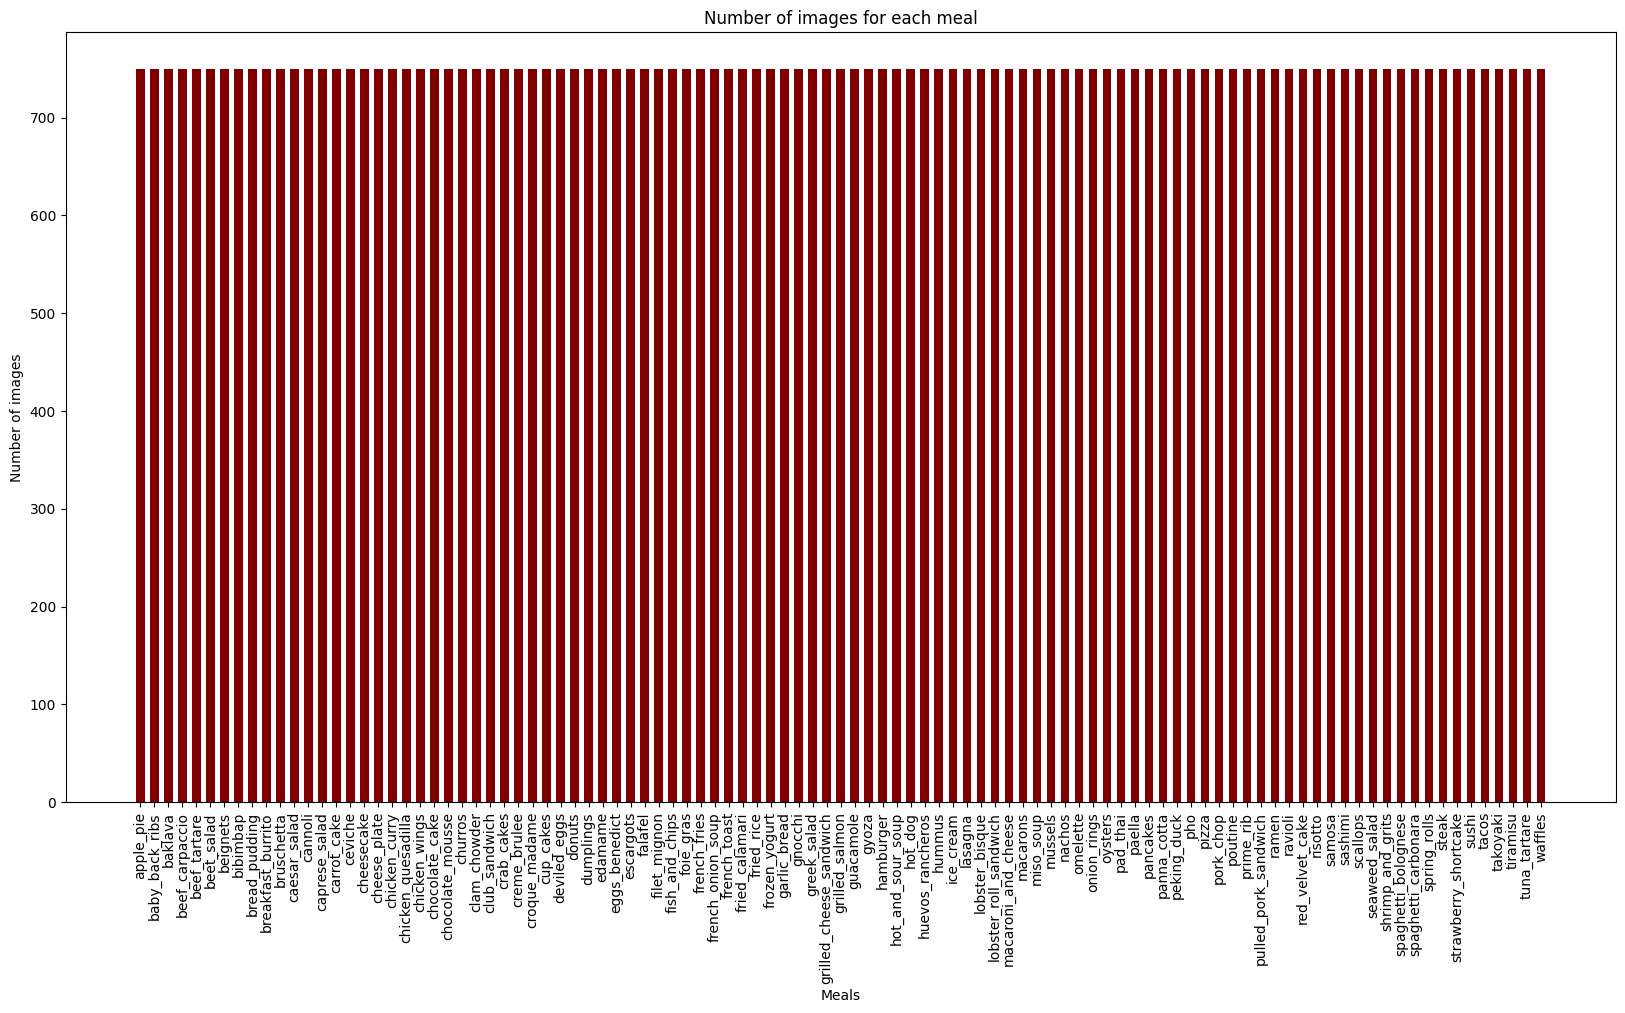

In [ ]:
meals = list(data_info.keys())
number_of_images = list(data_info.values())

fig = plt.figure(figsize = (20, 10))

# creating the bar plot
plt.bar(meals, number_of_images, color ='maroon',
        width = 0.6)

# Rotation of the bars names
plt.xticks(range(len(meals)), meals, rotation='vertical')

plt.xlabel("Meals")
plt.ylabel("Number of images")
plt.title("Number of images for each meal")
plt.show()

In [ ]:
IMAGE_SIZE = (256, 256)
L1_LAMBDA = 1e-4
L2_LAMBDA = 1e-4

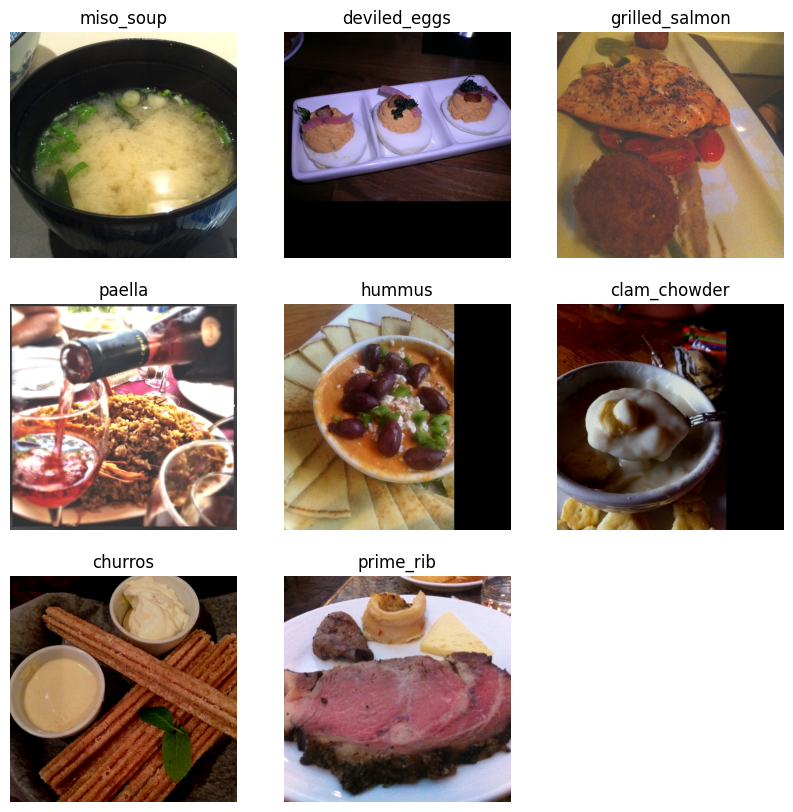

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        img = layers.RandomBrightness(factor=0.3, value_range=(0, 255))(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(train_metadata.features["label"].int2str(labels[i].numpy().astype("uint8")))
        plt.axis("off")

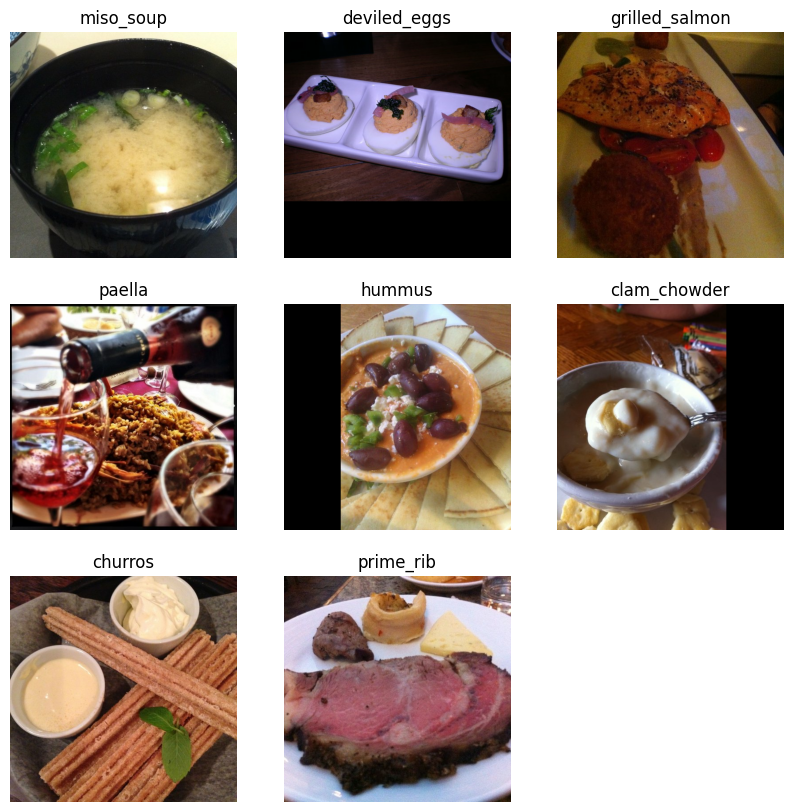

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        img = layers.RandomFlip("horizontal")(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(train_metadata.features["label"].int2str(labels[i].numpy().astype("uint8")))
        plt.axis("off")

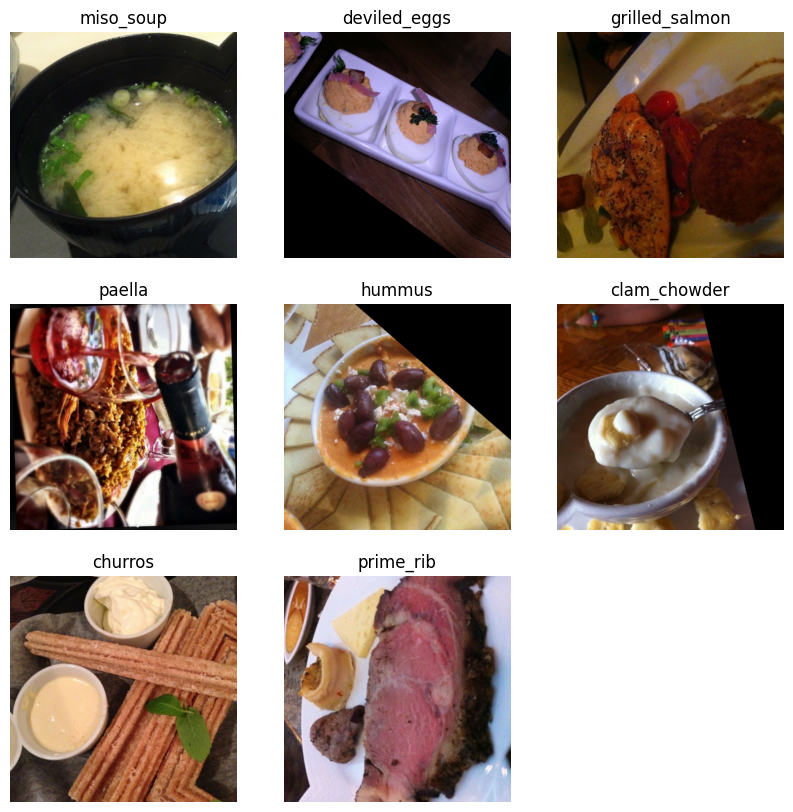

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        img = layers.RandomRotation(0.3)(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(train_metadata.features["label"].int2str(labels[i].numpy().astype("uint8")))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomBrightness(factor=0.3, value_range=(0, 255)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
    ]
)

resize_layer = layers.Resizing(*IMAGE_SIZE)

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (resize_layer(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
val_ds = val_ds.map(
    lambda img, label: (resize_layer(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    backbone = tf.keras.applications.InceptionV3(
        include_top=False,
        weights="imagenet"
    )
    x = backbone(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu",
                      kernel_regularizer=regularizers.L1(L1_LAMBDA),
                      activity_regularizer=regularizers.L2(L2_LAMBDA))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=101)

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/HsoubCourse/cps/old_save_at_26.keras")

In [ ]:
epochs = 7

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/HsoubCourse/cps/save_at_{epoch}.keras"),
]
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"],
# )
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/7
592/592 [==============================] - 1537s 2s/step - loss: 0.8550 - accuracy: 0.8222 - val_loss: 1.7205 - val_accuracy: 0.6573
Epoch 2/7
592/592 [==============================] - 1465s 2s/step - loss: 0.8253 - accuracy: 0.8303 - val_loss: 1.4403 - val_accuracy: 0.7052
Epoch 3/7
592/592 [==============================] - 1466s 2s/step - loss: 0.8059 - accuracy: 0.8335 - val_loss: 1.4823 - val_accuracy: 0.6995
Epoch 4/7
592/592 [==============================] - 1356s 2s/step - loss: 0.7915 - accuracy: 0.8371 - val_loss: 1.4887 - val_accuracy: 0.7055
Epoch 5/7
592/592 [==============================] - 1345s 2s/step - loss: 0.7574 - accuracy: 0.8455 - val_loss: 1.4748 - val_accuracy: 0.7051
Epoch 6/7
592/592 [==============================] - 1352s 2s/step - loss: 0.7328 - accuracy: 0.8516 - val_loss: 1.4551 - val_accuracy: 0.7156
Epoch 7/7
592/592 [==============================] - 1365s 2s/step - loss: 0.7170 - accuracy: 0.8556 - val_loss: 2.5773 - val_accuracy: 0.5469

In [ ]:
history = {
  "loss": [],
  "accuracy": [],
  "val_loss": [],
  "val_accuracy": [],
}

for i in range(1, 6 + 1):
  file_path = f'/content/history{i}.json'
  with open(file_path) as f:
    data = json.loads(f.read())
  for key in history:
    history[key].extend(data[key])

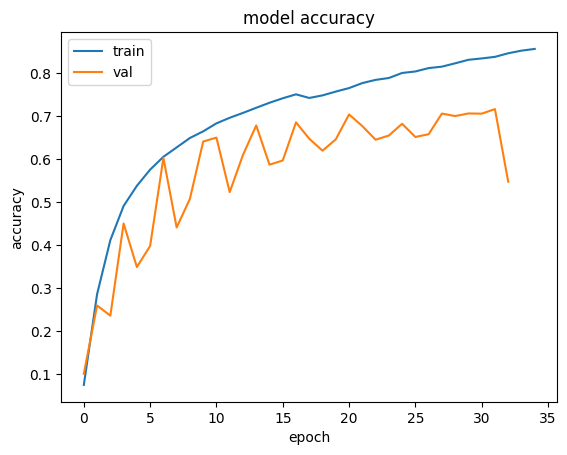

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

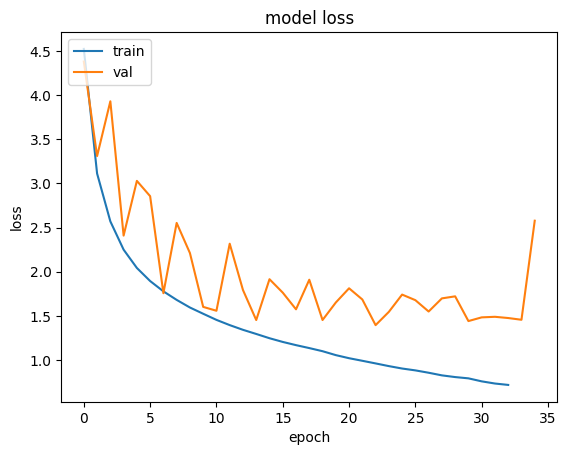

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
history.history

In [ ]:
import json

json.dump(history, open( "/content/total_history.json", 'w' ))

# Test

In [ ]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/HsoubCourse/cps/save_at_6.keras")

1/1 [==============================] - 0s 31ms/step


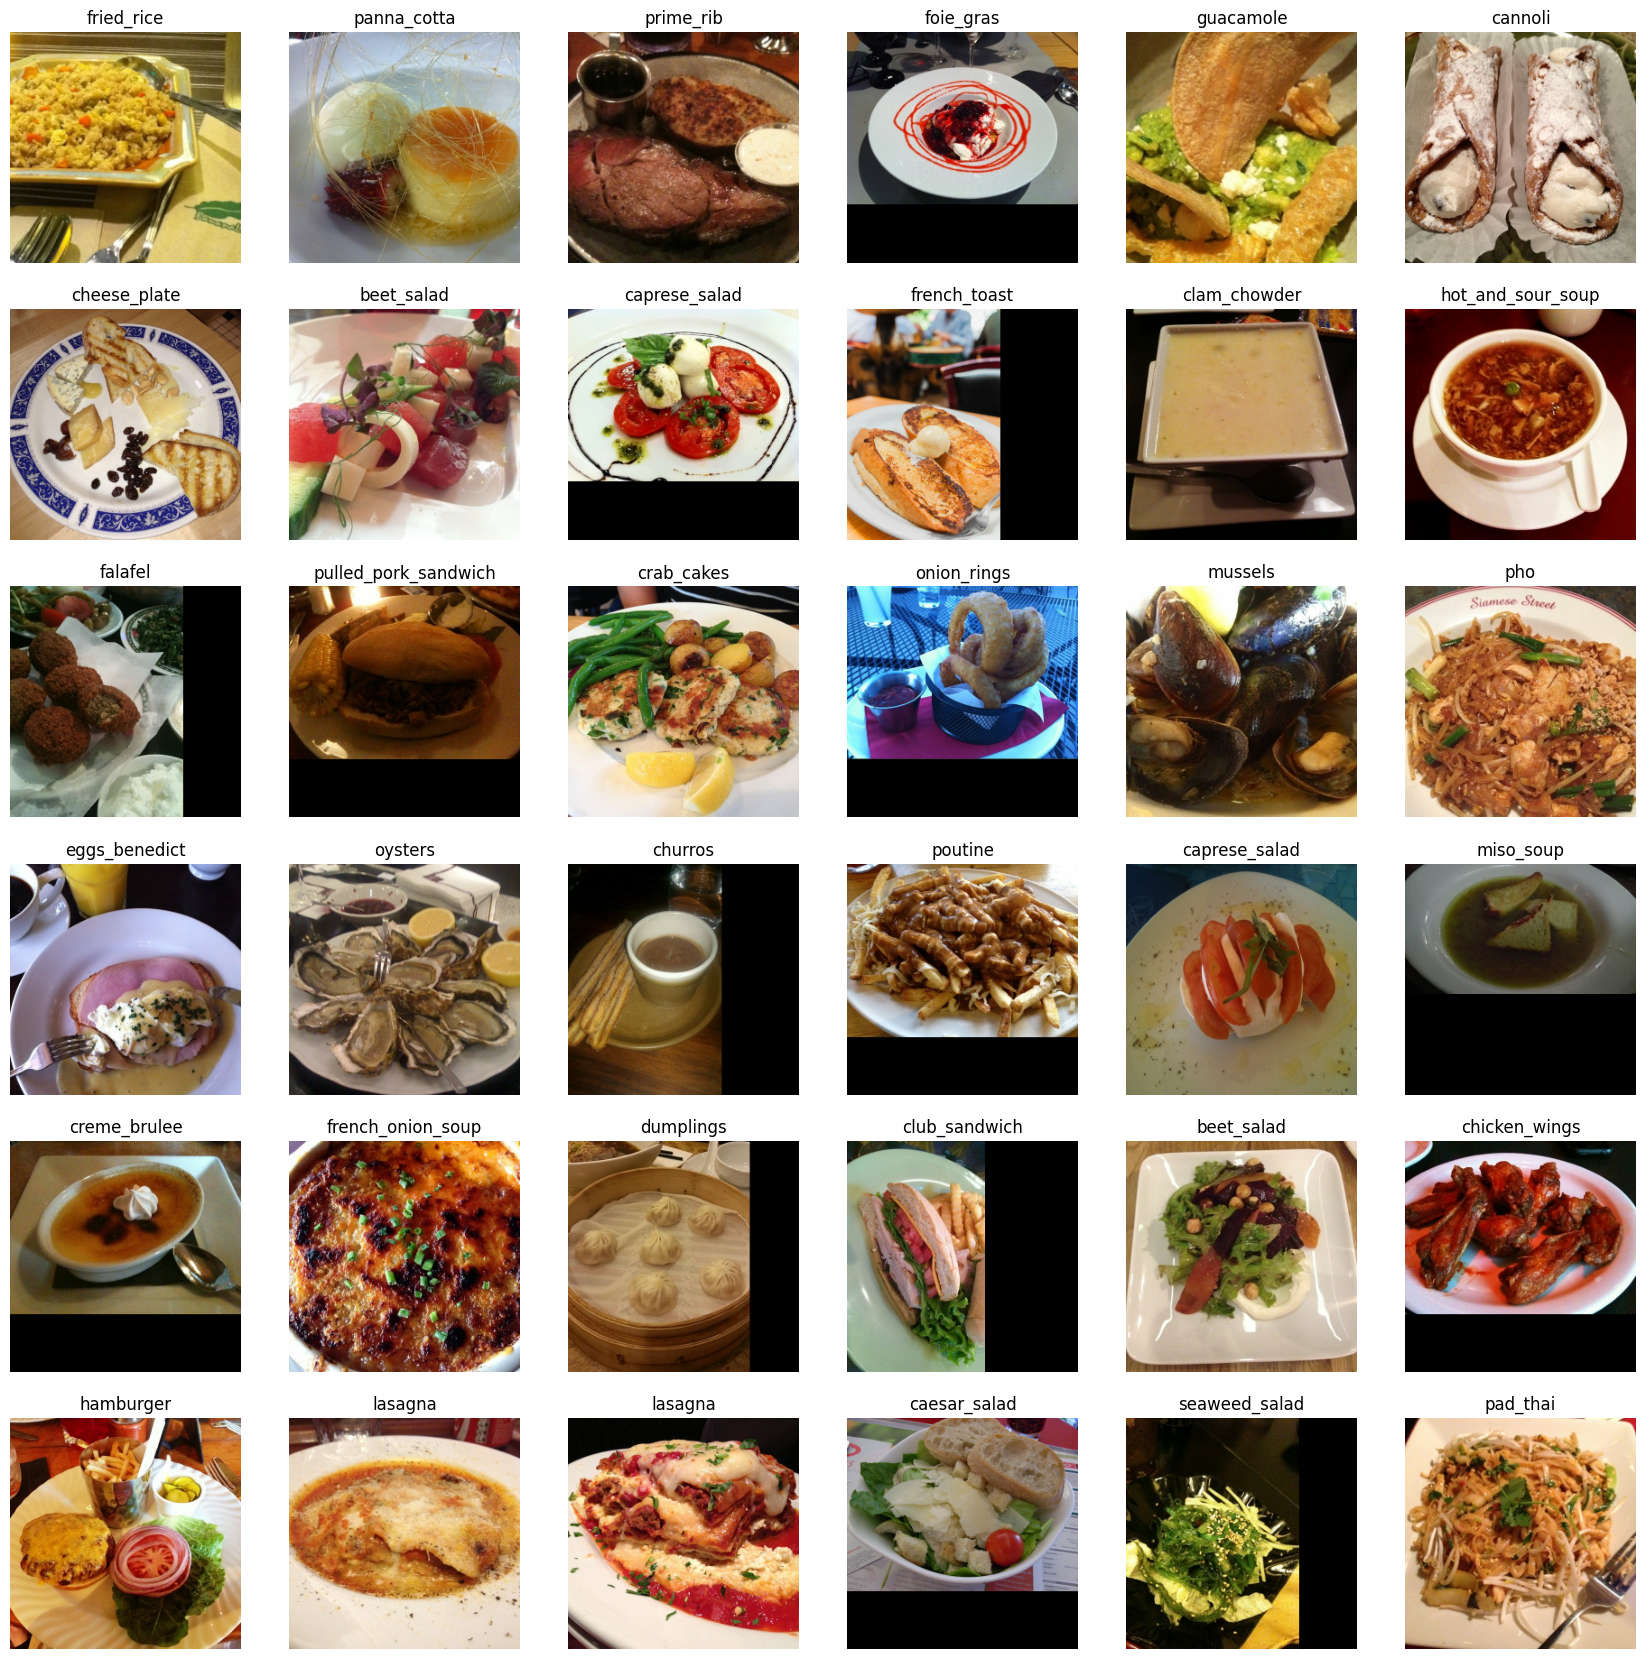

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(21, 21))
for images, labels in val_ds.take(1):
    for i in range(6*6):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        img_array = tf.expand_dims(images[i].numpy().astype("uint8"), 0)  # Create batch axis
        preds = loaded_model.predict(img_array)
        class_id = np.argmax(preds[0])
        class_name = train_metadata.features["label"].int2str(class_id)
        plt.title(class_name)
        plt.axis("off")